<a href="https://colab.research.google.com/github/Nebil1/UNDP-FTL-AI/blob/main/Task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Lab 4: plastics classification through computer vision

### Import libraries

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set Paths & Parameters

In [ ]:
import os, shutil
from sklearn.model_selection import train_test_split

src_dir = '/content/drive/MyDrive/Dataset_plastics_mhadlekar_UN'
dst_dir = '/content/drive/MyDrive/Dataset_plastics_mhadlekar_UN_split'

classes = ['HDPE', 'LDPA', 'PET', 'PP']
split_ratio = 0.75  # 75% for training, 25% for validation

for cls in classes:
    images = os.listdir(os.path.join(src_dir, cls))
    train_imgs, val_imgs = train_test_split(images, train_size=split_ratio, random_state=42)

    for t in ['train', 'val']:
        os.makedirs(os.path.join(dst_dir, t, cls), exist_ok=True)

    for img in train_imgs:
        shutil.copy(os.path.join(src_dir, cls, img), os.path.join(dst_dir, 'train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(src_dir, cls, img), os.path.join(dst_dir, 'val', cls, img))


In [ ]:
base_dir = '/content/drive/MyDrive/Dataset_plastics_mhadlekar_UN_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')

### Data Augmentation and Generators

In [ ]:
# Image and model config

in_shape = (256, 256, 3)
out_shape = 4  # PET, HDPE, PP, PS
batch_size = 32

In [ ]:
# Augmented data generator for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Only rescale validation data
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=in_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=in_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)

class_names = list(train_generator.class_indices.keys())

Found 432 images belonging to 4 classes.
Found 147 images belonging to 4 classes.


### Build VGG16 Model

In [ ]:
# Step 4: Build the Model (with fine-tuning)
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 base
vgg_base = VGG16(include_top=False, input_shape=in_shape, weights='imagenet')

# Fine-tune all of block 4 and block 5
for layer in vgg_base.layers:
    if 'block5' in layer.name or 'block4' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

# Classifier head
x = Flatten()(vgg_base.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(out_shape, activation='softmax')(x)

model = Model(inputs=vgg_base.input, outputs=output)

#  Use a moderately low learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,104,580 (88.14 MB)

 Trainable params: 21,369,092 (81.52 MB)

 Non-trainable params: 1,735,488 (6.62 MB)

###  Train the Model

In [ ]:
history = model.fit(train_generator, epochs=30, validation_data=val_generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1021s 73s/step - accuracy: 0.3336 - loss: 1.6449 - val_accuracy: 0.2721 - val_loss: 1.3100
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 974s 70s/step - accuracy: 0.3673 - loss: 1.2782 - val_accuracy: 0.4218 - val_loss: 1.2300
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 951s 68s/step - accuracy: 0.4920 - loss: 1.1972 - val_accuracy: 0.4762 - val_loss: 1.2241
Epoch 4/30
11/14 ━━━━━━━━━━━━━━━━━━━━ 2:59 60s/step - accuracy: 0.4479 - loss: 1.2258

In [ ]:
model.save("plastic_model.h5")

In [ ]:
from tensorflow.keras.models import load_model

model = load_model("plastic_model.h5")  # load previous best

model.save("plastic_model_v2.h5")

### Evaluate the Model


Accuracy Plot

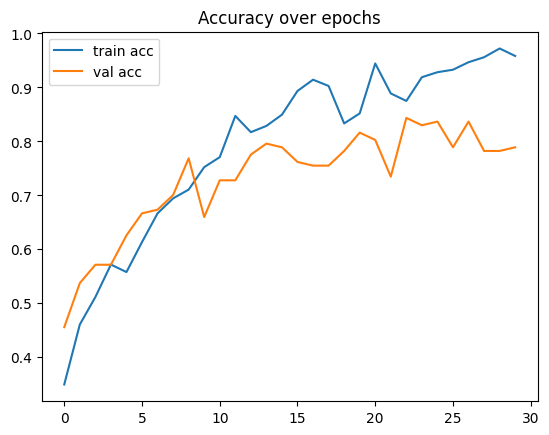

In [ ]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

Evaluation

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 393ms/step


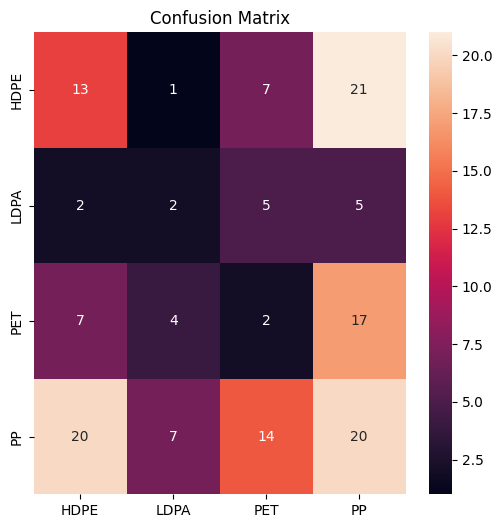

In [ ]:
val_generator.reset()
pred = model.predict(val_generator)
y_pred = np.argmax(pred, axis=1)
y_true = val_generator.classes

conf_mat = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(conf_mat, annot=True, xticklabels=class_names, yticklabels=class_names, fmt='d')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        HDPE       0.31      0.31      0.31        42
        LDPA       0.14      0.14      0.14        14
         PET       0.07      0.07      0.07        30
          PP       0.32      0.33      0.32        61

    accuracy                           0.25       147
   macro avg       0.21      0.21      0.21       147
weighted avg       0.25      0.25      0.25       147



### Image Prediction Function with Rejection Threshold

In [ ]:
def predict_image(path, threshold=0.6):
    img = image.load_img(path, target_size=in_shape[:2])
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prob = model.predict(img_array)[0]
    max_prob = np.max(prob)

    if max_prob < threshold:
        return "❌ Unknown or not a plastic type"
    else:
        return f"✅ {class_names[np.argmax(prob)]} ({max_prob:.2f} confidence)"

In [ ]:
from google.colab import files
files.download("plastic_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>